In [1]:
!set -e

!mkdir -p dataset
!cd dataset
!wget http://www.iro.umontreal.ca/~lisa/datasets/profiledata_06-May-2005.tar.gz
!tar xvf profiledata_06-May-2005.tar.gz
!mv profiledata_06-May-2005/* dataset/
!rm -r profiledata_06-May-2005

--2024-02-26 00:07:01--  http://www.iro.umontreal.ca/~lisa/datasets/profiledata_06-May-2005.tar.gz
Resolving www.iro.umontreal.ca (www.iro.umontreal.ca)... 132.204.26.36
Connecting to www.iro.umontreal.ca (www.iro.umontreal.ca)|132.204.26.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 135880312 (130M) [application/x-gzip]
Saving to: ‘profiledata_06-May-2005.tar.gz’

profiledata_06-May- 100%[===================>] 129.58M  81.9MB/s    in 1.6s    

2024-02-26 00:07:03 (81.9 MB/s) - ‘profiledata_06-May-2005.tar.gz’ saved [135880312/135880312]

profiledata_06-May-2005/
profiledata_06-May-2005/artist_data.txt
profiledata_06-May-2005/README.txt
profiledata_06-May-2005/user_artist_data.txt
profiledata_06-May-2005/artist_alias.txt


In [2]:
!cat dataset/user_artist_data.txt | head

1000002 1 55
1000002 1000006 33
1000002 1000007 8
1000002 1000009 144
1000002 1000010 314
1000002 1000013 8
1000002 1000014 42
1000002 1000017 69
1000002 1000024 329
1000002 1000025 1


In [3]:
!apt-get update # Update apt-get repository.
!apt-get install openjdk-8-jdk-headless -qq > /dev/null # Install Java.
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz # Download Apache Sparks.
!tar xf spark-3.1.1-bin-hadoop3.2.tgz # Unzip the tgz file.
!pip install -q findspark # Install findspark. Adds PySpark to the System path during runtime.

# Set environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

!ls

# Initialize findspark
import findspark
findspark.init()



Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [713 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,786 kB]
Get:13 http://archive.ubuntu.co

In [4]:
import os
import sys
import re
import random
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from time import time

sc = SparkContext()
sqlContext = SQLContext(sc)
# Base directory path
base = "dataset/"

In [5]:
userArtistDataSchema = StructType([ \
    StructField("userID", LongType(), True), \
    StructField("artistID", LongType(), True), \
    StructField("playCount", IntegerType(), True)])

userArtistDF = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .options(header='false', delimiter=' ') \
    .load(base + "user_artist_data.txt", schema = userArtistDataSchema) \
    .cache()

# we can cache an Dataframe to avoid computing it from the beginning everytime it is accessed.
userArtistDF.cache()

userArtistDF.show()

+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|1000002|       1|       55|
|1000002| 1000006|       33|
|1000002| 1000007|        8|
|1000002| 1000009|      144|
|1000002| 1000010|      314|
|1000002| 1000013|        8|
|1000002| 1000014|       42|
|1000002| 1000017|       69|
|1000002| 1000024|      329|
|1000002| 1000025|        1|
|1000002| 1000028|       17|
|1000002| 1000031|       47|
|1000002| 1000033|       15|
|1000002| 1000042|        1|
|1000002| 1000045|        1|
|1000002| 1000054|        2|
|1000002| 1000055|       25|
|1000002| 1000056|        4|
|1000002| 1000059|        2|
|1000002| 1000062|       71|
+-------+--------+---------+
only showing top 20 rows



In [6]:
allusers = userArtistDF.count()
print("All rows in database: ", allusers )
uniqueUsers = userArtistDF.select('userID').distinct().count()
print("Total no. of distinct users: ", uniqueUsers)

All rows in database:  24296858
Total no. of distinct users:  148111


In [7]:
uniqueArtists = userArtistDF.select('artistID').distinct().count()
print("Total no. of artists: ", uniqueArtists)

Total no. of artists:  1631028


In [8]:
MAX_VALUE = 2147483647
#showing the IDs which are invalid
userArtistDF[(userArtistDF.userID.cast("int") < 0)].show()
userArtistDF[(userArtistDF.userID.cast("int") > MAX_VALUE)].show()
#As the result, we don't see any invalid userID
#Otherwise, we can use function describe() of Spark MLlib to show the statistics
userArtistDF.select("userID").describe().show()

+------+--------+---------+
|userID|artistID|playCount|
+------+--------+---------+
+------+--------+---------+

+------+--------+---------+
|userID|artistID|playCount|
+------+--------+---------+
+------+--------+---------+

+-------+------------------+
|summary|            userID|
+-------+------------------+
|  count|          24296858|
|   mean|1947573.2653533637|
| stddev| 496000.5551820078|
|    min|                90|
|    max|           2443548|
+-------+------------------+



In [9]:
#Finding min and max of artistID using function groupby() and max|min()
max_artistID = userArtistDF.groupby().max('artistID').collect()[0].asDict()['max(artistID)']
print('Maximum value of artistID: ',max_artistID)
min_artistID = userArtistDF.groupby().min('artistID').collect()[0].asDict()['min(artistID)']
print('Minimum value of artistID: ',min_artistID)

#Again, we can use describe() for short
userArtistDF.select("artistID").describe().show()

Maximum value of artistID:  10794401
Minimum value of artistID:  1
+-------+------------------+
|summary|          artistID|
+-------+------------------+
|  count|          24296858|
|   mean|1718704.0937568964|
| stddev|2539389.0924284607|
|    min|                 1|
|    max|          10794401|
+-------+------------------+



In [10]:
# Compute user activity
# We are interested in how many playcounts each user has scored.
userActivity = userArtistDF.groupBy('userID').sum('playCount').collect()
print(userActivity[0:5])
len(userActivity)

[Row(userID=1000061, sum(playCount)=244), Row(userID=1000070, sum(playCount)=20200), Row(userID=1000313, sum(playCount)=201), Row(userID=1000832, sum(playCount)=1064), Row(userID=1000905, sum(playCount)=214)]


148111

[     0      1      2 ... 148108 148109 148110]


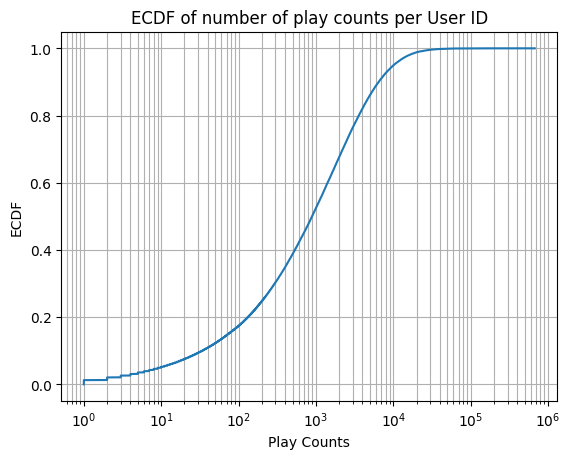

Total = 371638969
Mean = 2509.1922206993404
Min = 1
Max = 674412
Percentile 25% :204.0
Percentile 50% :892.0
Percentile 75% :2800.0
Percentile 90% :6484.0
Percentile 95% :10120.0
Percentile 99% :21569.199999999953
The percentage of user playing less than 10 times P(Y<=10) = 0.05228511049145573


In [11]:
pdf = pd.DataFrame(data=userActivity)
Y=np.sort( pdf[1] )
yvals=np.arange(len(Y))/float(len(Y))

print(np.arange(len(Y)))

plt.semilogx( Y, yvals )
plt.xlabel('Play Counts')
plt.ylabel('ECDF')
plt.grid(True,which="both",ls="-")
plt.title('ECDF of number of play counts per User ID')
plt.show()

#Morever, I would like to show some statistical measurements of userAcitvity
print ('Total =', Y.sum())
print ('Mean =', Y.mean())
print ('Min =', Y.min())
print ('Max =', Y.max())

# look at important percentiles (25%, median, 75%, tails such as >90%)
print('Percentile 25% :' + str(np.percentile(Y,25)))
print('Percentile 50% :' + str(np.percentile(Y,50)))
print('Percentile 75% :' + str(np.percentile(Y,75)))
print('Percentile 90% :' + str(np.percentile(Y,90)))
print('Percentile 95% :' + str(np.percentile(Y,95)))
print('Percentile 99% :' + str(np.percentile(Y,99)))

# look at the percentile has playCount less than 10
print('The percentage of user playing less than 10 times P(Y<=10) =', len(Y[Y<=10])/len(Y))

In [12]:
# Compute artist popularity
# We are interested in how many playcounts per artist
# ATTENTION! Grouping by artistID may be problematic, as stated above.

artistPopularity = userArtistDF.groupBy('artistID').sum('playCount').collect()
print(artistPopularity[0:5]) #print first 5 artistID in dataframe
len(artistPopularity)

[Row(artistID=1003514, sum(playCount)=949), Row(artistID=1004346, sum(playCount)=3772), Row(artistID=5409, sum(playCount)=526693), Row(artistID=1002519, sum(playCount)=405), Row(artistID=1004223, sum(playCount)=409)]


1631028

[      0       1       2 ... 1631025 1631026 1631027]


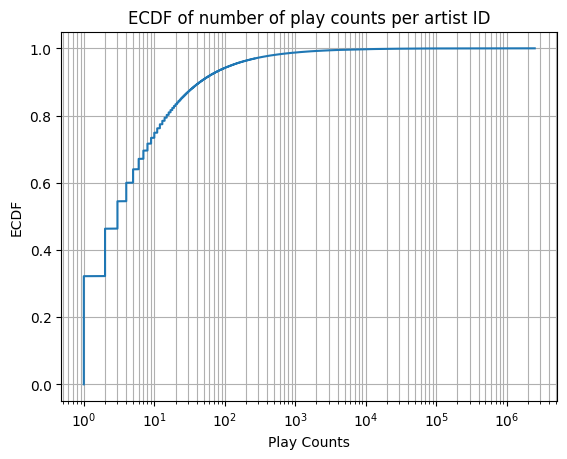

Sum = 371638969
Mean = 227.85566464830768
Min = 1
Max = 2502130
Top 5 play counts: [1425942 1542806 1930592 2259185 2502130]
Sum top 5 artist play counts: 9660655
Percentage of top 5 artist play counts: 0.025994730923925256
P(playCount<=10) = 0.7486793605014751
P(playCount<=1000) = 0.987435531456235


In [13]:
pdf1 = pd.DataFrame(data=artistPopularity)
Y1=np.sort( pdf1[1] )
yvals1=np.arange(len(Y1))/float(len(Y1))

print(np.arange(len(Y1)))

plt.semilogx( Y1, yvals1 )
plt.xlabel('Play Counts')
plt.ylabel('ECDF')
plt.grid(True,which="both",ls="-")
plt.title('ECDF of number of play counts per artist ID')
plt.show()



#
print ('Sum =', Y1.sum())
print ('Mean =', Y1.mean())
print ('Min =', Y1.min())
print ('Max =', Y1.max())
print ('Top 5 play counts:', Y1[len(Y1)-5:len(Y1)])
print ('Sum top 5 artist play counts:', Y1[len(Y1)-5:len(Y1)].sum())
print ('Percentage of top 5 artist play counts:', Y1[len(Y1)-5:len(Y1)].sum()/Y1.sum())
print ('P(playCount<=10) =', len(Y1[Y1<=10])/len(Y1))
print ('P(playCount<=1000) =', len(Y1[Y1<=1000])/len(Y1))

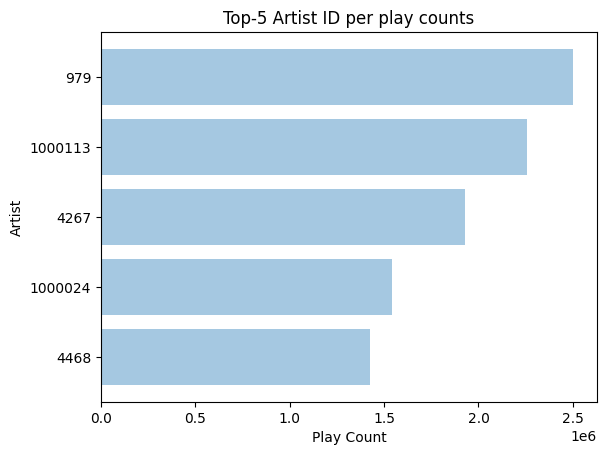

In [14]:
sortedArtist = sorted(artistPopularity, key = lambda x: -x[1])[:5]

artistID = [w[0] for w in sortedArtist]

y_pos = range(len(sortedArtist))
frequency = [w[1] for w in sortedArtist]

plt.barh(y_pos, frequency[::-1], align='center', alpha=0.4)
plt.yticks(y_pos, artistID[::-1])
plt.xlabel('Play Count')
plt.ylabel('Artist')
plt.title('Top-5 Artist ID per play counts')
plt.show()

In [15]:
customSchemaArtist = StructType([ \
    StructField("artistID", LongType(), True), \
    StructField("name", StringType(), True)])

artistDF = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .options(header='false', delimiter='\t', mode='DROPMALFORMED') \
    .load(base + "artist_data.txt", schema = customSchemaArtist) \
    .cache()
artistDF.show(5)

+--------+--------------------+
|artistID|                name|
+--------+--------------------+
| 1134999|        06Crazy Life|
| 6821360|        Pang Nakarin|
|10113088|Terfel, Bartoli- ...|
|10151459| The Flaming Sidebur|
| 6826647|   Bodenstandig 3000|
+--------+--------------------+
only showing top 5 rows



In [16]:
# get artists whose name contains "Aerosmith"
artistDF[locate("Aerosmith", artistDF.name) > 0].show(20, False)

# show two examples
artistDF[artistDF.artistID==1000010].show()
artistDF[artistDF.artistID==2082323].show()

+--------+----------------------------------------------+
|artistID|name                                          |
+--------+----------------------------------------------+
|10586006|Dusty Springfield/Aerosmith                   |
|6946007 |Aerosmith/RunDMC                              |
|10475683|Aerosmith: Just Push Play                     |
|1083031 |Aerosmith/ G n R                              |
|6872848 |Britney, Nsync, Nelly, Aerosmith,Mary J Blige.|
|10586963|Green Day - Oasis - Eminem - Aerosmith        |
|10028830|The Aerosmith Antology2                       |
|10300357|Run-DMC + Aerosmith                           |
|2027746 |Aerosmith by MusicInter.com                   |
|1140418 |[rap]Run DMC and Aerosmith                    |
|10237208|Aerosmith + Run DMC                           |
|10588537|Aerosmith, Kid Rock, & Run DMC                |
|9934757 |Aerosmith - Big Ones                          |
|10437510|Green Day ft. Oasis & Aerosmith               |
|6936680 |RUN 

In [17]:
customSchemaArtistAlias = StructType([ \
    StructField("mispelledID", LongType(), True), \
    StructField("standardID", LongType(), True)])

artistAliasDF = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .options(header='false', delimiter='\t', mode='DROPMALFORMED') \
    .load(base + "artist_alias.txt", schema = customSchemaArtistAlias) \
    .cache()

artistAliasDF.show(5)

+-----------+----------+
|mispelledID|standardID|
+-----------+----------+
|    1092764|   1000311|
|    1095122|   1000557|
|    6708070|   1007267|
|   10088054|   1042317|
|    1195917|   1042317|
+-----------+----------+
only showing top 5 rows



In [18]:
artistAliasDF[artistAliasDF.mispelledID == "1000010" ].show()
artistAliasDF[artistAliasDF.mispelledID == "2082323" ].show()

+-----------+----------+
|mispelledID|standardID|
+-----------+----------+
+-----------+----------+

+-----------+----------+
|mispelledID|standardID|
+-----------+----------+
|    2082323|   1000010|
+-----------+----------+



In [19]:
artistAlias = artistAliasDF.rdd.map(lambda row: (row.mispelledID,row.standardID)).collectAsMap()

#checking the total number of standard artistID
len(artistAlias)

190893

In [20]:
from time import time

bArtistAlias = sc.broadcast(artistAlias)

def replaceMispelledIDs(fields):
    finalID = bArtistAlias.value.get(fields[1] ,fields[1])
    return (fields[0], finalID, fields[2])

t0 = time()

newUserArtistDF = sqlContext.createDataFrame(
    userArtistDF.rdd.map(replaceMispelledIDs),
    userArtistDataSchema
)
newUserArtistDF.show(5)
t1 = time()

print('The script takes %f seconds' %(t1-t0))
newUserArtistDF = newUserArtistDF.cache()

+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|1000002|       1|       55|
|1000002| 1000006|       33|
|1000002| 1000007|        8|
|1000002| 1000009|      144|
|1000002| 1000010|      314|
+-------+--------+---------+
only showing top 5 rows

The script takes 0.862698 seconds


In [1]:
uniqueArtists = newUserArtistDF.select('artistID').distinct().count()

print("Total no. of artists: ", uniqueArtists[0:100])

In [1]:
top10ArtistsPC = newUserArtistDF.groupBy('artistID').sum('playCount').orderBy('sum(playCount)', ascending=0).take(10)

y_pos = list(range(len(top10ArtistsPC)))
pdf = pd.DataFrame(data=top10ArtistsPC)

plt.barh(y_pos, pdf[1][::-1], align='center', alpha=0.4)
plt.yticks(y_pos, pdf[0][::-1])
plt.xlabel('Play Count')
plt.ylabel('Artist')
plt.title('Top-10 Artist ID per play counts')
plt.show()

In [ ]:
top10UsersByPlayCount = newUserArtistDF.groupBy("userID").sum('playCount').orderBy('sum(playCount)', ascending=0).take(10)

y_pos = list(range(len(top10UsersByPlayCount)))
pdf = pd.DataFrame(data=top10UsersByPlayCount)

plt.barh(y_pos, pdf[1][::-1], align='center', alpha=0.4)
plt.yticks(y_pos, pdf[0][::-1])
plt.xlabel('Play Count')
plt.ylabel('User')
plt.title('Top-10 Users ID per play counts')
plt.show()

In [ ]:
top10UsersByCuriosity = (newUserArtistDF.dropDuplicates(['userID', 'artistID'])
                             .groupBy("userID")
                             .count()
                             .orderBy('count', ascending=0)
                             .take(10)
                         )

#print(top10UsersByCuriosity)
y_pos = range(len(top10UsersByCuriosity))

pdf = pd.DataFrame(data=top10UsersByCuriosity)

plt.barh(y_pos, pdf[1][::-1], align='center', alpha=0.4)
plt.yticks(y_pos, pdf[0][::-1])
plt.xlabel('Number of played artists')
plt.ylabel('User')
plt.title('Top-10 Users ID per Curiosity')
plt.show

In [ ]:
rawArtistAlias = sc.textFile(base + "artist_alias.txt")

def xtractFields(s):
    # Using white space or tab character as separetors,
    # split a line into list of strings
    line = re.split("\s|\t",s,1)
    # if this line has at least 2 characters
    if (len(line) > 1):
        try:
            # try to parse the first and the second components to integer type
            return (int(line[0]), int(line[1]))
        except ValueError:
            # if parsing has any error, return a special tuple
            return (-1,-1)
    else:
        # if this line has less than 2 characters, return a special tuple
        return (-1,-1)

artistAlias = (
                rawArtistAlias
                    # extract fields using function xtractFields
                    .map( lambda x: xtractFields(x))

                    # fileter out the special tuples
                    .filter( lambda x: x != (-1,-1) )
                    # collect result to the driver as a "dictionary"
                    .collectAsMap()
                )

In [ ]:
bArtistAlias = sc.broadcast(artistAlias)
rawUserArtistData = sc.textFile(base + "user_artist_data.txt")

def disambiguate(line):
    [userID, artistID, count] = line.split(' ')
    finalArtistID = bArtistAlias.value.get(artistID,artistID)
    return (userID, finalArtistID,count)


userArtistDataRDD = rawUserArtistData.map(disambiguate)
userArtistDataRDD.take(5)

In [ ]:
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

In [ ]:
allData = userArtistDataRDD.map(lambda r: Rating( float(r[0]),float(r[1]),int(r[2]))) \
                                            .repartition(12).cache()
allData.take(5)

In [ ]:
rank=10
iterations=5
lambda_=0.01
alpha=1.0

#training
t0 = time()
model = ALS.trainImplicit(allData, rank)
t1 = time()
print("finish training model in %f secs" % (t1 - t0))

In [ ]:
model.save(sc,'music_rec_model.spark')
print('Save new model')

In [ ]:
t0 = time()
model = MatrixFactorizationModel.load(sc, 'music_rec_model.spark')
t1 = time()
print("finish loading model in %f secs" % (t1 - t0))

In [ ]:
model.userFeatures().first()

In [ ]:
recommendations = (model.recommendProducts(2093760,5))
print(recommendations)
# construct set of recommendated artists
recArtist = set(rating[1] for rating in recommendations)
recArtist

In [ ]:
rawArtistData = sc.textFile(base + "artist_data.txt")

def xtractFields(s):
    line = re.split("\s|\t",s,1)
    if (len(line) > 1):
        try:
            return (int(line[0]), str(line[1].strip()))
        except ValueError:
            return (-1,"")
    else:
        return (-1,"")

In [ ]:
def artistNames(line):
#     [artistID, name]
    if (line[0] in recArtist):
        return True
    else:
        return False

recList = artistByID.filter(artistNames).values().collect()

print(recList)

In [ ]:
def unpersist(model):
    model.userFeatures().unpersist()
    model.productFeatures().unpersist()

# uncache data and model when they are no longer used
unpersist(model)

In [ ]:
trainData, cvData = allData.randomSplit([0.7,0.3],1)
trainData.cache()
cvData.cache()

In [ ]:
t0 = time()
model = ALS.trainImplicit(ratings=trainData,rank=rank,iterations=iterations,lambda_=lambda_ ,alpha=alpha)
t1 = time()
print("finish training model in %f secs" % (t1 - t0))

In [ ]:
allItemIDs = np.array(allData.map(lambda x: x[1]).distinct().collect())
bAllItemIDs = sc.broadcast(allItemIDs)

In [ ]:
from random import randint
def xtractNegative(userIDAndPosItemIDs):
    def pickEnoughNegatives(line):
        userID = line[0]
        posItemIDSet = set(line[1])
        #posItemIDSet = line[1]
        negative = []
        allItemIDs = bAllItemIDs.value
        # Keep about as many negative examples per user as positive. Duplicates are OK.
        i = 0
        while (i < len(allItemIDs) and len(negative) < len(posItemIDSet)):
            itemID = allItemIDs[randint(0,len(allItemIDs)-1)]
            if itemID not in posItemIDSet:
                negative.append(itemID)
            i += 1

        # Result is a collection of (user,negative-item) tuples
        return map(lambda itemID: (userID, itemID), negative)

    # Init an RNG and the item IDs set once for partition
    # allItemIDs = bAllItemIDs.value
    return map(pickEnoughNegatives, userIDAndPosItemIDs)


In [ ]:
def ratioOfCorrectRanks(positiveRatings, negativeRatings):

    # find number elements in arr that has index >= start and has value smaller than x
    # arr is a sorted array
    def findNumElementsSmallerThan(arr, x, start=0):
        left = start
        right = len(arr) -1
        # if x is bigger than the biggest element in arr
        if start > right or x > arr[right]:
            return right + 1
        mid = -1
        while left <= right:
            mid = (left + right) // 2
            if arr[mid] < x:
                left = mid + 1
            elif arr[mid] > x:
                right = mid - 1
            else:
                while mid-1 >= start and arr[mid-1] == x:
                    mid -= 1
                return mid
        return mid if arr[mid] > x else mid + 1
  correct = 0 ## L
  total = 0 ## L
  negativeRatings = list(map(lambda x:x.rating, negativeRatings))

    #np.sort(positiveRatings)
    negativeRatings.sort()# = np.sort(negativeRatings)
    total = len(positiveRatings)*len(negativeRatings)

    for positive in positiveRatings:
        # Count the correctly-ranked pairs
        correct += findNumElementsSmallerThan(negativeRatings, positive.rating)

    ## Return AUC: fraction of pairs ranked correctly
    return float(correct) / total

def calculateAUC(positiveData, bAllItemIDs, predictFunction):
    # Take held-out data as the "positive", and map to tuples
    positiveUserProducts = positiveData.map(lambda r: (r[0], r[1]))
    # Make predictions for each of them, including a numeric score, and gather by user
    positivePredictions = predictFunction(positiveUserProducts).groupBy(lambda r: r.user)

    # Create a set of "negative" products for each user. These are randomly chosen
    # from among all of the other items, excluding those that are "positive" for the user.
    negativeUserProducts = positiveUserProducts.groupByKey().mapPartitions(xtractNegative).flatMap(lambda x: x)
    # Make predictions on the rest
    negativePredictions = predictFunction(negativeUserProducts).groupBy(lambda r: r.user)

    return (
            positivePredictions.join(negativePredictions)
                .values()
                .map(
                    lambda positive_negativeRatings: ratioOfCorrectRanks(positive_negativeRatings[0], positive_negativeRatings[1])
                )
                .mean()
            )

In [ ]:
t0 = time()
auc = calculateAUC( cvData,bAllItemIDs, model.predictAll)
t1 = time()
print("auc=",auc)
print("finish in %f seconds" % (t1 - t0))

In [ ]:
bListenCount = sc.broadcast(trainData.map(lambda r: (r[1], r[2])).reduceByKey(lambda x,y: x+y).collectAsMap())
def predictMostListened(allData):
    return allData.map(lambda r: Rating(r[0], r[1], bListenCount.value.get( r[1], 0.0)))
auc = calculateAUC(cvData,bListenCount, predictMostListened)
print("AUC score:" + str(auc))

In [ ]:
evaluations = []

for rank in [10, 50]:
    for lambda_ in [1.0, 0.0001]:
        for alpha in [1.0, 40.0]:
            print("Train model with rank=%d lambda_=%f alpha=%f" % (rank, lambda_, alpha))
            # with each combination of params, we should run multiple times and get avg
            # for simple, we only run one time.
            model = ALS.trainImplicit(ratings=trainData,rank=rank,iterations=5,lambda_=lambda_ ,alpha=alpha)
            auc = calculateAUC(cvData,bListenCount,model.predictAll)

            evaluations.append(((rank, lambda_, alpha), auc))

            unpersist(model)

evaluations.sort(key = lambda x: -x[1])
evalDataFrame = pd.DataFrame(data=evaluations)
print(evalDataFrame)

trainData.unpersist()
cvData.unpersist()

In [ ]:
model = ALS.trainImplicit(ratings=trainData, rank=10, iterations=5, lambda_=1.0, alpha=40.0)
allData.unpersist()

userID = 2093760
recommendations = model.recommendProducts(userID,5)

recArtist = set(rating[1] for rating in recommendations)

# Filter in those artists, get just artist, and print
def artistNames(line):
#     [artistID, name]
    if (line[0] in recArtist):
        return True
    else:
        return False

recList = artistByID.filter(artistNames).values().collect()
print(recList)

unpersist(model)

In [ ]:
trainData, cvData = allData.randomSplit([0.5,0.5],1)
trainData.cache()
cvData.cache()

t0 = time()
model = ALS.trainImplicit(ratings=trainData,rank=rank,iterations=iterations,lambda_=lambda_ ,alpha=alpha)
t1 = time()
print("finish training model in %f secs" % (t1 - t0))

t0 = time()
auc = calculateAUC( cvData,bAllItemIDs, model.predictAll)
t1 = time()
print("auc=",auc)
print("finish in %f seconds" % (t1 - t0))

In [ ]:
trainData, cvData = allData.randomSplit([0.8,0.2],1)
trainData.cache()
cvData.cache()

t0 = time()
model = ALS.trainImplicit(ratings=trainData,rank=rank,iterations=iterations,lambda_=lambda_ ,alpha=alpha)
t1 = time()
print("finish training model in %f secs" % (t1 - t0))

t0 = time()
auc = calculateAUC( cvData,bAllItemIDs, model.predictAll)
t1 = time()
print("auc=",auc)
print("finish in %f seconds" % (t1 - t0))

In [ ]:
trainData, cvData = allData.randomSplit([0.9,0.1],1)
trainData.cache()
cvData.cache()

t0 = time()
model = ALS.trainImplicit(ratings=trainData,rank=rank,iterations=iterations,lambda_=lambda_ ,alpha=alpha)
t1 = time()
print("finish training model in %f secs" % (t1 - t0))

t0 = time()
auc = calculateAUC( cvData,bAllItemIDs, model.predictAll)
t1 = time()
print("auc=",auc)
print("finish in %f seconds" % (t1 - t0))

In [ ]:
trainData, cvData = allData.randomSplit([0.99,0.01],1)
trainData.cache()
cvData.cache()

t0 = time()
model = ALS.trainImplicit(ratings=trainData,rank=rank,iterations=iterations,lambda_=lambda_ ,alpha=alpha)
t1 = time()
print("finish training model in %f secs" % (t1 - t0))

t0 = time()
auc = calculateAUC( cvData,bAllItemIDs, model.predictAll)
t1 = time()
print("auc=",auc)
print("finish in %f seconds" % (t1 - t0))

In [ ]:
trainData, cvData = allData.randomSplit([0.7,0.3],1)
trainData.cache()
cvData.cache()

In [ ]:
model50 = ALS.trainImplicit(ratings=trainData, rank=10, iterations=5)
trainData.unpersist()

userID = 2093760
recommendations50 = model50.recommendProducts(userID,50)

recArtist = set(rating[1] for rating in recommendations50)

recList50 = artistByID.filter(artistNames).values().collect()

print(recList50)

unpersist(model)

In [ ]:
model50_1 = ALS.trainImplicit(ratings=trainData, rank=10, iterations=5, lambda_= 0.0001, alpha= 40.0)
trainData.unpersist()

userID = 2093760
recommendations50_1 = model50_1.recommendProducts(userID,50)

recArtist = set(rating[1] for rating in recommendations50_1)

recList50_1 = artistByID.filter(artistNames).values().collect()

print(recList50_1)

unpersist(model)

In [ ]:
temp3 = [item for item in recList50 if item not in recList50_1]
print(temp3)
print("\n Number of different artists between standard model and model_1:" + str(len(temp3)))

In [ ]:
model50_2 = ALS.trainImplicit(ratings=trainData, rank=10, iterations=5, lambda_= 0.1, alpha= 1.0)
trainData.unpersist()

userID = 2093760
recommendations50_2 = model50_2.recommendProducts(userID,50)

recArtist = set(rating[1] for rating in recommendations50_2)

recList50_2 = artistByID.filter(artistNames).values().collect()

print(recList50_2)

unpersist(model)

In [ ]:
temp4 = [item for item in recList50 if item not in recList50_2]
print(temp4)
print("\n Number of different artists between standard model and model_2:" + str(len(temp4)))